<a href="https://colab.research.google.com/github/livinNector/deep-learning-tools-lab/blob/main/3%20-%20Deep%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Deep Neural Networks

## Classification using Deep Neural Networks

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Dataset Used

Titanic Dataset : https://www.tensorflow.org/datasets/catalog/titanic

### Loading Dataset

In [2]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [3]:
df = pd.read_csv(titanic_file_path)

In [4]:
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
df.rename(columns = {"survived":"target"},inplace=True)

In [6]:
np.random.seed(5)
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [7]:
train

,target,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
445,0,male,57.0,0,0,12.3500,Second,unknown,Queenstown,y
230,1,female,31.0,0,2,164.8667,First,C,Southampton,n
289,1,male,39.0,0,0,7.9250,Third,unknown,Southampton,y
622,0,male,28.0,0,0,10.5000,Second,unknown,Southampton,y
361,0,female,37.0,0,0,9.5875,Third,unknown,Southampton,y
...,...,...,...,...,...,...,...,...,...,...
572,0,male,35.0,0,0,10.5000,Second,unknown,Southampton,y
54,0,male,26.0,2,0,8.6625,Third,unknown,Southampton,n
19,0,male,28.0,0,0,7.2250,Third,unknown,Cherbourg,y
609,1,female,27.0,1,0,13.8583,Second,unknown,Cherbourg,n


In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [9]:
batch_size = 10
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

### Preprocessing the dataset

References:
1. Classifying Structured data using keras preprocessing layers - https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
2. keras preprocessing layers - https://www.tensorflow.org/guide/keras/preprocessing_layers

The titanic dataset is preprocessed using the following keras preprocessing layers:
- `tf.keras.layers.Normalization`
- `tf.keras.layers.CategoryEncoding`
- `tf.keras.layers.StringLookup`
- `tf.keras.layers.IntegerLookup`




In [10]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer


In [11]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))


In [12]:
numerical_cols = ["age","fare"]
numerical_categorical_cols = ["n_siblings_spouses","parch"]
categorical_cols = ["sex","class","deck","embark_town","alone"]

all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds) # Normalization
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Numerical Categorial features
for header in numerical_categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  encoding_layer = get_category_encoding_layer(name=header,dataset=train_ds,dtype='int64') # encoding
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Other categorical Features
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,dataset=train_ds,dtype='string',max_tokens=5) # encoding
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


### Creating the model

In [13]:
x = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
x = tf.keras.layers.Dense(4, activation="relu")(x)
x = tf.keras.layers.Dense(2, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(all_inputs,outputs)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

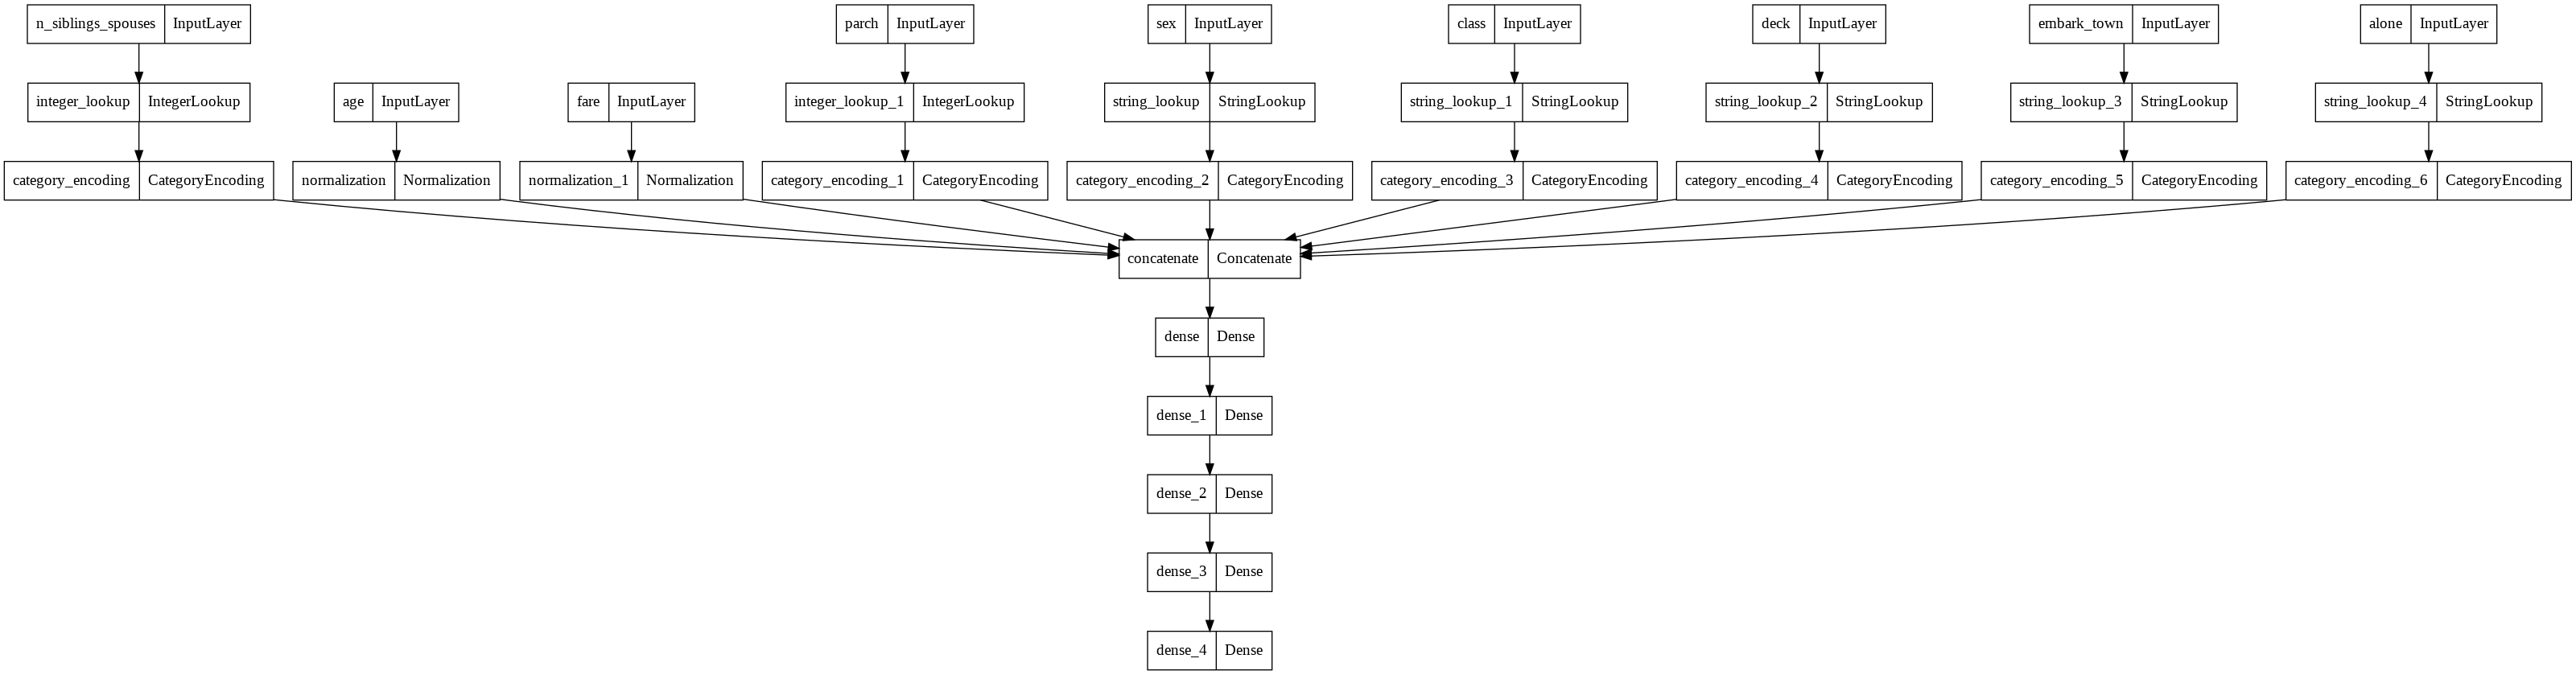

In [14]:
tf.keras.utils.plot_model(model)

### Training the model

In [15]:
history = model.fit(train_ds,validation_data=val_ds,epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


51/51 [==============================] - 2s 11ms/step - loss: 0.7937 - accuracy: 0.4511 - val_loss: 0.6897 - val_accuracy: 0.5397
Epoch 2/50
51/51 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6447 - val_loss: 0.6590 - val_accuracy: 0.6508
Epoch 3/50
51/51 [==============================] - 0s 3ms/step - loss: 0.6352 - accuracy: 0.7285 - val_loss: 0.6238 - val_accuracy: 0.6825
Epoch 4/50
51/51 [==============================] - 0s 4ms/step - loss: 0.5985 - accuracy: 0.7685 - val_loss: 0.5821 - val_accuracy: 0.7619
Epoch 5/50
51/51 [==============================] - 0s 4ms/step - loss: 0.5624 - accuracy: 0.8004 - val_loss: 0.5475 - val_accuracy: 0.8095
Epoch 6/50
51/51 [==============================] - 0s 8ms/step - loss: 0.5345 - accuracy: 0.8204 - val_loss: 0.5201 - val_accuracy: 0.8254
Epoch 7/50
51/51 [==============================] - 0s 8ms/step - loss: 0.5158 - accuracy: 0.8224 - val_loss: 0.4981 - val_accuracy: 0.8413
Epoch 8/50
51/51 [============

### Ploting learing curves

In [16]:
history = history.history

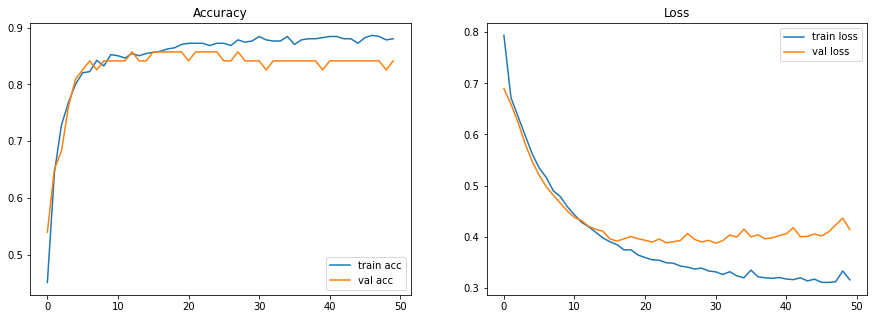

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()

### Testing the model on test set

In [18]:
loss ,accuracy = model.evaluate(test_ds)

7/7 [==============================] - 0s 3ms/step - loss: 0.6833 - accuracy: 0.7143


In [19]:
print("test loss :",loss)
print("test accuracy :",accuracy)

test loss : 0.68325275182724
test accuracy : 0.7142857313156128
